# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information



## Laboratoire 7 - Réseaux de neurones convolutifs (CNN) - classification et régression
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                  | CODE PERMANENT  |  PARTICIPATION     |
|-----------------------|-----------------|--------------------|
| Étudiant1             | Code1           |      0%            |
| Étudiant2             | Code2           |      0%            |
| Étudiant3             | Code3           |      0%            |

## Introduction
Ce laboratoire porte sur l'apprentissage de la représentation (primitives) et du discriminant d'une façon intégrée avec des réseaux neuronaux convolutifs

Vous devez proposer des architectures CNN aﬁn de résoudre deux problèmes: prédiction de l'âge de personnes à partir de photos du visage (régression - dataset FG-NET); prédiction des émotions à partir de photos du visage (classification - dataset FER), introduits dans le cadre des laboratoires précédents.

L’évaluation de ce laboratoire sera basée sur:
- la qualité des réseaux de neurones proposés et utilisés; (10%)
- utilisation du protocole et mesures de performance appropriées; (10%)
- les réponses aux questions dans ce notebook;(70%)
- l'organisation de votre code source (SVP, n'oubliez pas de mettre des commentaires dans le code source!); (10%)

# Modules et bibliotèques python

### Import de bibliotèques

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [5]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import pandas as pd
import os
import re
from PIL import Image
import numpy as np
import re 
import face_recognition
import cv2
from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

from skimage import io, exposure, filters, transform, color
from skimage.color import rgb2gray

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, top_k_accuracy_score

### Définition des fonctions

In [ ]:
def fa():
    return 1

# Partie 1 - Apprentissage de représentation et régression avec FG-NET (40%)

Point de départ: fichier *fg-net-nxm.csv* - images nettoyées et normalisées avec résolution $n$ $\times$ $m$.

## 1a: Données de FG-NET. (10%)

###  <font color=blue> À faire: </font>
1. Reprenez vos images FG-NET savaugardées dans un fichier *csv*. Vous devez lire ces images et les représenter sous la forme d’une matrice $X\_data$ aussi que les vecteurs $Y\_data$ avec les âges (étiquettes) et $Z\_data$ avec les id des sujets.

In [15]:
data = np.loadtxt('fg-net-128x104.csv.csv', delimiter=',',dtype=str)
#data = np.loadtxt('content/fg-net-4x4-restNET50v2.csv', delimiter=',',dtype=str)
#data = np.loadtxt('content/fg-net-nxm.csv.csv', delimiter=',',dtype=str)


def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

x_data = transform_str_float(data[1:,2])
y_data = np.array(data[1:,1], dtype=int)
z_data = np.array(data[1:,0], dtype=int)

print(f"fg-net:\t{x_data.shape[1]} features")



pca = PCA(n_components=1000)
x_data_pca = pca.fit_transform(x_data)

print(f"pca:\t{x_data_pca.shape[1]} features")

print(f"fg-net:\t{x_data_pca.shape[0]} samples")



X_data = x_data

##Print shape of X_data
print(X_data.shape)
X_data = np.reshape(X_data, (X_data.shape[0],128, 104,3))
print(X_data.shape) 

##Print shape of y_data
print(y_data.shape)

##Print shape of z_data
print(z_data.shape)


fg-net:	39936 features
pca:	1000 features
fg-net:	1000 samples
(1000, 39936)
(1000, 128, 104, 3)
(1000,)
(1000,)


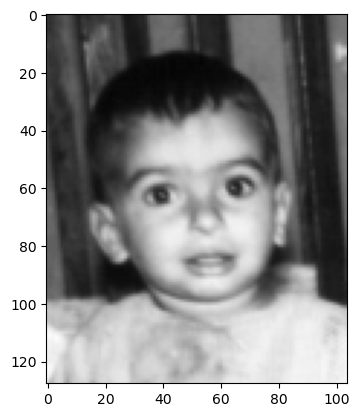

In [17]:

#Testing to see if the images appear well
image = X_data[0]
plt.imshow(image)
plt.show()



  2.  **Explications:**

Définition du protocole expérimental avec FG-NET.

Idéalement, vous devez utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).

Cependant, en raison des longs temps d'apprentissage des CNNs, un tel protocole expérimental n'est pas réalisable. Par conséquent, vous êtes invité à établir un protocole "hold-out" pour l'ensemble de données FG-NET.

Je vous suggère une répartition 50% - 20% - 30% entraînement-validation-test. Cependant, vous devez faire cette répartition "par sujet" pour vous assurer que les visages d'un même sujet ne sont présents que sur une seule partition.

Par exemple, en supposant 10 sujets avec 20 visages chacun. Vous aurez un ensemble d’entraînement avec 5 sujets (sujets A, B, C, D, E - 100 images de visage), un ensemble de validation avec 2 sujets (sujets F, G - 40 images de visage) et un ensemble de tests avec 3 sujets (sujets H, I, J - 60 images de visage).

  **A faire:** Créer trois partitions de données à partir des images de FG-NET:
    - Ensemble d'entraînement - *D_train* (50% x 82) = 41 sujets
    - Ensemble de validation - *D_valid* (20% x 82) = 17 sujets
    - Ensemble de tests - *D_test* (30% x 82) = 24 sujets <br><br>
    
    Ici, vous devez aussi faire attention pour ne changer pas la distribution d'âges dans les partitions de données (stratified sampling).

In [23]:


#Seprating the data into training and testing data

#Each ID has a number of image, a distribution and a mean age

#We need to separate these samples without disturbing the distribution of the data

id_ages = {}
for id in np.unique(z_data):
    id_ages[id] = y_data[z_data == id].tolist()

print(id_ages)



{1: [2, 5, 8, 10, 14, 16, 18, 19, 22, 28, 29, 33, 40, 43, 43], 2: [3, 4, 5, 7, 12, 15, 16, 18, 20, 21, 23, 26, 29, 31, 36, 38], 3: [18, 20, 23, 25, 35, 38, 47, 49, 51, 58, 60, 61], 4: [19, 21, 26, 28, 30, 37, 40, 48, 51, 53, 62, 63], 5: [18, 24, 30, 31, 35, 40, 45, 48, 49, 52, 61], 6: [24, 28, 31, 36, 40, 42, 46, 51, 55, 61, 67, 69], 7: [1, 18, 22, 23, 26, 37, 38, 39, 45], 8: [3, 6, 8, 12, 13, 16, 17, 18, 21, 29, 30, 31, 33, 35, 41], 9: [0, 1, 3, 5, 9, 11, 13, 14, 16, 16, 18, 22, 22], 10: [1, 4, 5, 6, 7, 7, 9, 10, 12, 15, 16, 18], 11: [2, 5, 7, 11, 13, 14, 15, 17, 20, 27, 30, 34, 40, 42], 12: [4, 7, 12, 14, 18, 21, 23, 24, 25, 26, 27, 30, 32, 34, 36], 13: [0, 8, 16, 18, 19, 21, 23, 25, 30, 34, 41, 44], 14: [12, 14, 16, 18, 22, 30, 36, 40, 42], 15: [0, 1, 3, 4, 5, 7, 9, 10, 12, 14, 15, 17, 19], 16: [1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19], 17: [5, 7, 12, 15, 17, 19, 22, 26, 29, 32, 36, 38, 42], 18: [6, 11, 16, 18, 22, 25, 28, 29, 33, 34, 36], 19: [0, 3, 5, 7, 12, 15, 18, 23, 27, 3

In [38]:
from sklearn.model_selection import train_test_split

# Create a DataFrame from the dictionary
data = {'ID': list(id_ages.keys()), 'Ages': list(id_ages.values())}
df = pd.DataFrame(data)

# Flatten the age lists to compute overall age distribution
all_ages = [age for sublist in df['Ages'] for age in sublist]

# Calculate the distribution of ages
age_distribution = pd.Series(all_ages).value_counts(normalize=True).sort_index()

# Calculate age distribution for each ID
def calculate_id_distribution(df):
    age_distributions = {}
    for index, row in df.iterrows():
        age_distributions[row['ID']] = pd.Series(row['Ages']).value_counts(normalize=True).sort_index()
    return pd.DataFrame(age_distributions).fillna(0).T

# Get the age distribution for each ID
id_distributions = calculate_id_distribution(df)

# First, split the IDs into train and temp (which will be split into validation and test)
train_ids, temp_ids = train_test_split(id_distributions.index, test_size=0.5, random_state=42)

# Then, split the temp set into validation and test
val_ids, test_ids = train_test_split(temp_ids, test_size=0.4, random_state=42)

# Create the final train, validation, and test DataFrames
train_df = df[df['ID'].isin(train_ids)]
val_df = df[df['ID'].isin(val_ids)]
test_df = df[df['ID'].isin(test_ids)]

# Function to calculate age distribution for a subset of data
def calculate_distribution(subset):
    subset_ages = [age for sublist in subset['Ages'] for age in sublist]
    return pd.Series(subset_ages).value_counts(normalize=True).sort_index()

# Ensure that the split preserves the distribution
train_dist = calculate_distribution(train_df)
val_dist = calculate_distribution(val_df)
test_dist = calculate_distribution(test_df)

# Output the results
print("Training Set")
print(train_df[['ID', 'Ages']])
print("\nTraining Distribution")
print(train_dist)

print("\nValidation Set")
print(val_df[['ID', 'Ages']])
print("\nValidation Distribution")
print(val_dist)

print("\nTest Set")
print(test_df[['ID', 'Ages']])
print("\nTest Distribution")
print(test_dist)

print("\nOverall Distribution")
print(age_distribution)

Training Set
    ID                                               Ages
1    2  [3, 4, 5, 7, 12, 15, 16, 18, 20, 21, 23, 26, 2...
2    3   [18, 20, 23, 25, 35, 38, 47, 49, 51, 58, 60, 61]
3    4   [19, 21, 26, 28, 30, 37, 40, 48, 51, 53, 62, 63]
6    7                [1, 18, 22, 23, 26, 37, 38, 39, 45]
8    9    [0, 1, 3, 5, 9, 11, 13, 14, 16, 16, 18, 22, 22]
11  12  [4, 7, 12, 14, 18, 21, 23, 24, 25, 26, 27, 30,...
14  15      [0, 1, 3, 4, 5, 7, 9, 10, 12, 14, 15, 17, 19]
15  16     [1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19]
17  18        [6, 11, 16, 18, 22, 25, 28, 29, 33, 34, 36]
20  21      [3, 5, 6, 11, 16, 18, 20, 23, 27, 30, 35, 39]
21  22  [0, 7, 11, 14, 16, 18, 20, 23, 25, 26, 27, 28,...
23  24          [0, 5, 7, 10, 17, 18, 19, 23, 25, 28, 30]
24  25         [3, 7, 12, 15, 18, 19, 22, 23, 28, 34, 39]
26  27        [2, 11, 13, 16, 18, 20, 22, 25, 30, 36, 41]
27  28       [14, 16, 18, 20, 26, 28, 34, 35, 37, 41, 46]
29  30           [0, 4, 5, 7, 10, 16, 17, 18, 20, 23, 26]
3

In [39]:
print("The IDs for the training set are:")
print(train_ids)

print("The IDs for the validation set are:")
print(val_ids)

print("The IDs for the test set are:")
print(test_ids)

X_train = X_data[np.isin(z_data, train_ids)]
y_train = y_data[np.isin(z_data, train_ids)]
z_train = z_data[np.isin(z_data, train_ids)]

X_val = X_data[np.isin(z_data, val_ids)]
y_val = y_data[np.isin(z_data, val_ids)]
z_val = z_data[np.isin(z_data, val_ids)]

X_test = X_data[np.isin(z_data, test_ids)]
y_test = y_data[np.isin(z_data, test_ids)]
z_test = z_data[np.isin(z_data, test_ids)]


The IDs for the training set are:
Index([ 4, 18, 39,  9, 65,  7, 37, 74, 66, 51, 47, 81, 16, 28, 42, 27, 49, 25,
       44, 73, 58, 12, 33, 78, 60, 64, 71, 38, 30,  2, 53, 22,  3, 24, 77, 75,
       21, 61, 72, 15, 52],
      dtype='int64')
The IDs for the validation set are:
Index([20, 55, 31, 56, 29, 34,  1, 62, 79, 23, 80, 26, 32, 68, 48, 82, 50,  6,
       57, 10, 54, 70, 17, 45],
      dtype='int64')
The IDs for the test set are:
Index([35, 36, 5, 67, 19, 59, 41, 14, 40, 11, 43, 69, 63, 13, 46, 8, 76], dtype='int64')


In [45]:

print("The percentage of Train to data is : ", (X_train.shape[0]/X_data.shape[0])*100)
print("The percentage of Validation to data is : ", (X_val.shape[0]/X_data.shape[0])*100)
print("The percentage of Test to data is : ", (X_test.shape[0]/X_data.shape[0])*100)

print("\nTraining shape:", X_train.shape)

print("Validation shape", X_val.shape)

print("Test Shape",X_test.shape)

The percentage of Train to data is :  50.9
The percentage of Validation to data is :  28.7
The percentage of Test to data is :  20.4

Training shape: (509, 128, 104, 3)
Validation shape (287, 128, 104, 3)
Test Shape (204, 128, 104, 3)


In [54]:
D_train = z_train
D_valid = z_val
D_test = z_test



3. Générez un fichier *fg-net-nxm-split.csv* avec les données nettoyées et normalisées, où $n$ et $m$ représentent la résolution finale des images. En fait, vous devez prendre le fichier *fg-net-nxm.csv* et ajouter, l'usage de chaque image (similaire à FER2013)
   - Format du fichier: subject,age,pixels,use
      * sujet: integer
      * âge: integer
      * pixels: integer [0, 255]
      * use: nominal [training, validation, test]<br><br>

In [46]:
data = []
for i in range(len(X_train)):
    img = X_train[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_train[i], y_train[i] ,ch_str, "training"]
    data.append(row)

for i in range(len(X_val)):
    img = X_val[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_val[i], y_val[i] ,ch_str, "validation"]
    data.append(row)

for i in range(len(X_test)):
    img = X_test[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_test[i], y_test[i] ,ch_str, "test"]
    data.append(row)




# Create a DataFrame
columns = ['id', 'age', 'pixels', 'usage']
df = pd.DataFrame(data, columns=columns)

n = 128
m = 104
# Save to CSV
df.to_csv(f"content/fg-net-{n}x{m}-split.csv", index=False)

## 1b: Architecture CNN Régression FG-NET. (20%)
Point de départ: fichier *fg-net-nxm.csv* or *D_train*, *D_val*, *D_test*

1. Générer des partitions de données pour entraîner le CNN:
    - Ensemble d'entraînement: *X_train* et *y_train*
    - Ensemble de validation : *X_valid* et *y_val*
    - Ensemble de test       : *X_test* et  *y_test* <br><br>
    


In [57]:
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape,     'z_train shape:', z_train.shape)
print('X_val shape:', X_val.shape,   'y_val shape:', y_val.shape, 'z_val shape:', z_val.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape, 'z_test shape:', z_test.shape)


X_train shape: (509, 128, 104, 3) y_train shape: (509,) z_train shape: (509,)
X_val shape: (287, 128, 104, 3) y_val shape: (287,) z_val shape: (287,)
X_test shape: (204, 128, 104, 3) y_test shape: (204,) z_test shape: (204,)


2. Utiliser Pytorch ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/regression) pour construire un réseau de neurones convolutifs pour extraire les primitives et faire la regression (end-to-end learning); Proposer une architecture appropriée pour FG-NET : nombre de couches convolutifs (CLs), nombre et dimension des filtres de chaque couche (kernel size), pas (stride), nombre et dimension des couches entièrement connectées (FC), fonctions d'activation de chaque couche, couches supplémentaires comme normalisation de batch, dropout, etc.

3. Entraîner et optimiser les paramètres du réseau (modèle 1).


5. Entraîner un autre modèle avec "data augmentation" pour améliorer la généralisation (modèle 2).



6. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les réseaux de neurones de convolution. Comparer avec les résultats obtenus avec les CNNs avec ceux obtenus dans les laboratoires précédents concernant des modèles de régression (TPs 5 et 6).



| Algorithme            | Paramètres    |  MSE  |  MAE  | ????? |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         |               |94.96  | 4.47  |  4.61%   |
| Regr Ridge            | alpha = 0.7   |94.91  | 7.46  |  4.72%   |
| KNN                   | k = 4         |235.93 | 10.46 |  8.24%   |
| MLP 1                 | 1024:512:1 |8.752 |9.59 | 29.93 %      |
| MLP 2                 | 512:128:1      |8.337. |126.47 |    31.48%   |
| CNN 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| CNN 2 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |

## 1c: Fine-tuning d'un CNN pré-entraîné pour FG-NET. (10%)

1. Récupérer une architecture CNN pré-entraînée disponible dans Pytorch ou Keras pour faire un “transfert de connaissance (transfer learning). Faire un "fine-tuning" du modèle choisi sur FG-NET puis expliquer les modifications/adaptations apportées au modèle pré-entraîné (p. ex., description de couches ajoutées ou enlevées pour faire fonctionner le modèle sur vos données)



2. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les réseaux de neurones de convolution. Comparer avec les résultats obtenus avec les CNNs avec ceux obtenus dans les laboratoires précédents concernant des modèles de régression (TPs 5 et 6).

| Algorithme            | Paramètres    |  MSE  |  MAE  | ????? |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         | XXX.XX        |XXX.XX |XXX.XX |       |
| Regr Ridge            | alpha = 0.1   |123.34 | 10.45 |       |
| Regr Lasso            | XXX.XX        |XXX.XX |XXX.XX |       |
| Regr ElasticNet       | XXX.XX        |XXX.XX |XXX.XX |       |
| MLP 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| MLP 2                 | 512:50:1      |XXX.XX |XXX.XX |       |
| CNN 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| CNN 2 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |
| VGG16 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |

Votre description ici

# Partie 2 - Apprentissage de représentation et classification avec FER (30%)

Point de départ: fichier *fer2013-clean-pre.csv* - images nettoyées et normalisées.

## 2: Architecture CNN Classification FER2013 (30%)


###  <font color=blue> À faire: </font>
1. Reprenez votre ensemble de données nettoyé et repérez les trois partitions de données: apprentissage, validation et test.

In [ ]:
# Load data
ferData = np.loadtxt( 'fer2013-clean-pre.csv', delimiter=',', dtype=str )

# Images d'entraînement
Xtrain = <à compléter>
ytrain = <à compléter>

# Images de validation
Xval = <à compléter>
yval = <à compléter>

# Images de test
Xtest = <à compléter>
ytest = <à compléter>

print(Xtrain.shape, Xval.shape, Xtest.shape)

2. Utiliser Pytorch ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif (classe) qui vous servira par la suite à apprendre une représentation des images de visage (primitives) et faire la classification (end-to-end learning). Vous pouvez reprendre l'architecture de la partie 1 avec quelques adaptations pour qu'il fonctionne sur ce problème.


2. Entraîner et optimiser les paramètres du réseau (modèle 1).


3. Entraîner un autre modèle avec "data augmentation" pour améliorer la généralisation (modèle 2).


4. Prenez le modèle le plus performant pour faire la prédiction sur tous les exemples (apprentissage, validation, test) et rapporter les résultats (comme fait dans les TP1 à TP4 et TP6):<br>
   3a. Rapport de classification produit avec *<font color=green>from sklearn.metrics import classification_report</font>*<br>
   3b. taux de classification correct sur les trois (3) ensembles de données (sous la forme d'un tableau)<br>
   3c. matrice de confusion produite avec *<font color=green> from sklearn.metrics import confusion_matrix</font>* pour les résultats sur l'ensemble de tests (matrice 7 $\times$ 7 - étiquettes $\times$ prédictions)



5. Comparez les résultats avec ceux attendus avec le réseau MLP (TP6), les primitives « deep » réduits (TP4), les primitives « deep » (TP3), les primitives globales/locales (TP2) et *template matching* (TP1)



6. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur la pertinence / advantages / désavantages des réseaux neuronaux.